# Imports

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rtree
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar

import rasterio
import rasterio.plot

import matplotlib.pylab as pl
from matplotlib import rc

## Figure Formatting

In [2]:
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')

fo = "#73956F"
pr = "#F37748"
we = "#336699"
nd = "#52154E"
ep = "#EADEDA"

fs = 20
lts = 15
#https://coolors.co/eadeda-f37748-73956f-336699-52154e

## Preprocessing

In [3]:
parcels = gpd.read_file("data/parcels.shp")

towns = gpd.read_file("data/townssurvey_shp/TOWNSSURVEY_POLY.shp")
towns.head()

f = towns[towns["TOWN"] == "FRANKLIN"]

In [4]:
parcels = parcels[parcels["t_as_val_x"]>0]
parcels.columns

npp = parcels[(parcels["LEV_PROT"] != "P") & (parcels["LEV_PROT"] != "T")& 
              (parcels["LEV_PROT"] != "L") & (parcels["LEV_PROT"] != "N") & (parcels["LEV_PROT"] != "X")]
              #& parcels["CH61_TYPE"].isna()]
npp = npp[npp['t_as_val_x']>0]



pp =parcels[(parcels["LEV_PROT"] == "P") | (parcels["LEV_PROT"] == "T")|
            (parcels["LEV_PROT"] == "L") | (parcels["LEV_PROT"]== "N") | (parcels["LEV_PROT"] == "X")] #| ~(parcels["CH61_TYPE"].isna())]

## Create Functions

In [5]:
BUDGET = 1000000

def priority_parcels(df, metric): #sort ascending
    npp = df
    #sort based on metric (low to high)
    npp = npp.sort_values(by=metric)
    #replace inf values with nan and drop
    npp[metric].replace([np.inf, -np.inf], np.nan, inplace=True)
    # Drop rows with NaN
    #npp.dropna(inplace=True)

    #calculate cummulative sum of parcel cost
    npp['ce_cost_pred_usd_sum'] = npp['t_as_val_x'].cumsum()
    
    #select parcels less than budget
    i=npp['ce_cost_pred_usd_sum'].lt(BUDGET)
    
    #return dataframe of selected parcels
    return(npp[i])

def priority_parcels2(df, metric):  #sort descending
    npp = df
    #sort based on metric (low to high)
    npp = npp.sort_values(by=metric,ascending=False )
    #replace inf values with nan and drop
    #npp[metric].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    
    # Drop rows with NaN
    #npp.dropna(inplace=True)
    
    npp = npp[npp["t_as_val_x"] < BUDGET]

    #calculate cummulative sum of parcel cost
    npp['ce_cost_pred_usd_sum'] = npp['t_as_val_x'].cumsum()
    
    #select parcels less than budget
    i=npp['ce_cost_pred_usd_sum'].lt(BUDGET)
    
    #return dataframe of selected parcels
    return(npp[i])




def outcomes(scenario, selected_parcels, metric_area, scenario_df):
    dm_select = selected_parcels
    
    n = len(dm_select.index)
    area_t= sum(dm_select['area_x'])/4046.85642
    
    metric_a = sum(dm_select[metric_area])/4046.85642#total area of avoided forest loss in hectare
    budget = sum(dm_select['t_as_val_x']) #total cost for the conservation easements in $, assuming that the indicated price is paid 
    
    #avg_usd_metric = budget/metric_a
    
    summary =pd.DataFrame({"scenario": [scenario],
                          "n": [n], 
                          "area_acre": [area_t],
                          "metric_area_acre": [metric_a],
                          "budget": [budget]})
   #                       "cost per metric": [avg_usd_metric]})
    
    if scenario_df.empty:
        return(summary)
    else:
        return(scenario_df.append(summary))
    
def plot_scenarios(relev_parcels, opt, large, inexpensive, color, title, save_name):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey="row")

    #inputs: all relevant parcels, select parcels (opt, large, inexpensive), color
    #        first title, save name

    #Plot 1: All relevant space
    pp.plot(ax = ax1, color = ep)
    relev_parcels.plot(ax = ax1, color = color)
    f.plot(ax = ax1, color = "#00000000", edgecolor = "black")
    ax1.axis('off')
    ax1.set_title(title,fontsize=fs)

    #Plot 2: Optimal Allocation
    pp.plot(ax = ax2, color = ep)
    opt.plot(ax = ax2, color = color)
    f.plot(ax = ax2, color = "#00000000", edgecolor = "black")
    ax2.axis('off')
    ax2.set_title("Optimal Selection",fontsize=fs)

    #Plot 3: Largest Parcels
    pp.plot(ax = ax3, color = ep)
    large.plot(ax = ax3, color = color)
    f.plot(ax = ax3, color = "#00000000", edgecolor = "black")
    ax3.axis('off')
    ax3.set_title("Largest Parcels",fontsize=fs)

    #Plot 4: Least Expensive Parcels
    pp.plot(ax = ax4, color = ep)
    inexpensive.plot(ax = ax4, color = color)
    f.plot(ax = ax4, color = "#00000000", edgecolor = "black")
    ax4.axis('off')
    ax4.set_title("Least Expensive Parcels",fontsize=fs)

    #create legend
    handles = [Patch(facecolor=ep,label='Existing Protected Areas'),
               Patch(facecolor=color,label=title)]

    ax1.legend(handles=handles,bbox_to_anchor=(0,-0.15), fontsize = lts, loc="lower left")

    
    fig.set_size_inches(20, 20/1.618)
    savename = "figures/" + save_name
    plt.savefig(savename, bbox_inches='tight')

# Overview Maps

## State

In [6]:
#roads = gpd.read_file("data/roads/CENSUS2010TIGERROADS_ARC.shp")
#roads=gpd.clip(roads, f)
#roads.to_file("data/roads/roads_clip.shp")
roads = gpd.read_file("data/roads/roads_clip.shp")

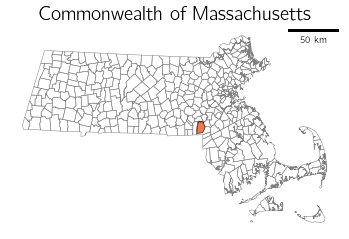

In [7]:
fig, ax = plt.subplots()
towns.plot(ax=ax, color='none', edgecolor='gray', linewidth = 0.5)
f.plot(ax=ax, color=pr, edgecolor='black', linewidth = 0.5)
ax.axis('off')
ax.add_artist(ScaleBar(1))
#fig.set_size_inches(19/1.618, 19)
ax.set_title("Commonwealth of Massachusetts",fontsize=fs)
plt.savefig('figures/state.png', bbox_inches='tight')

## Developed Area

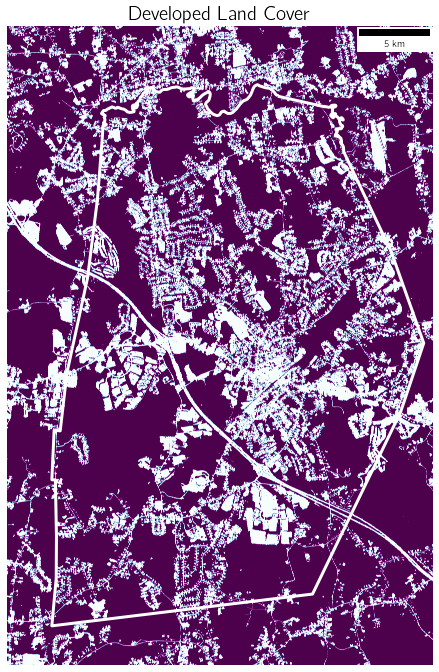

In [8]:
raster = rasterio.open("data/2016_HighResLandCover/developed.tif")

ymax = 2880000
ymin = 2835000

xmax = 695000
xmin = 665000

fig, ax = plt.subplots()
rasterio.plot.show(raster, ax=ax, cmap = "BuPu_r")

#parcels[(parcels["LEV_PROT"] == "P")].plot(color = ep, ax = ax)
#parcels.to_crs(raster.crs).plot(color = "#00000000", ax = ax, legend= True)
#roads.plot(ax = ax, color = "black")

f.to_crs(raster.crs).plot(ax=ax, color='none', edgecolor='white', linewidth = 3)

ax.add_artist(ScaleBar(1))
ax.set_title("Developed Land Cover",fontsize=fs)
plt.xlim(xmax=xmax, xmin=xmin)
plt.ylim(ymax=ymax, ymin=ymin)

ax.axis('off')
fig.set_size_inches(19,19/1.618)
plt.savefig('figures/developed.png', bbox_inches='tight')

## Tax Value

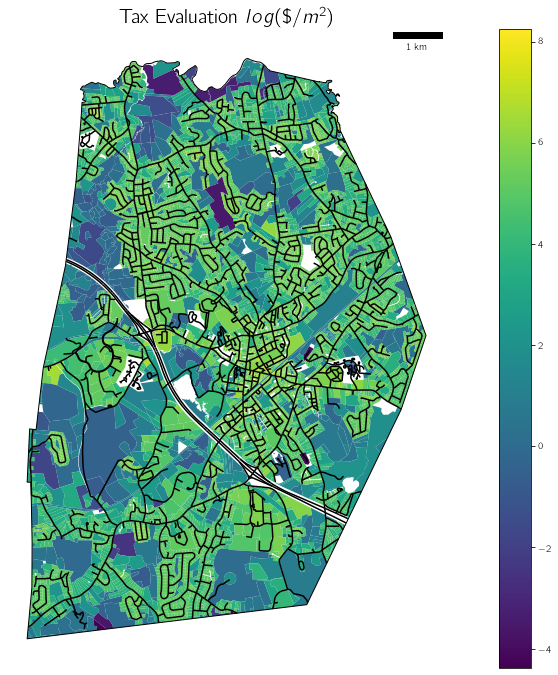

In [9]:
parcels["log_val_per_ar"] = np.log(parcels["val_per_ar"])

fig, ax = plt.subplots()

#parcels[(parcels["LEV_PROT"] == "P")].plot(color = ep, ax = ax)

parcels.plot("log_val_per_ar",cmap = "viridis", 
             ax = ax, legend= True,
              )

roads.plot(ax = ax, color = "black")

f.plot(ax=ax, color='none', edgecolor='black')

ax.add_artist(ScaleBar(1))
ax.set_title("Tax Evaluation $log (\$/m^2)$",fontsize=fs)

ax.axis('off')
fig.set_size_inches(19,19/1.618)

plt.savefig('figures/landval.png', bbox_inches='tight')

## Existing Protected Areas and Ch 61

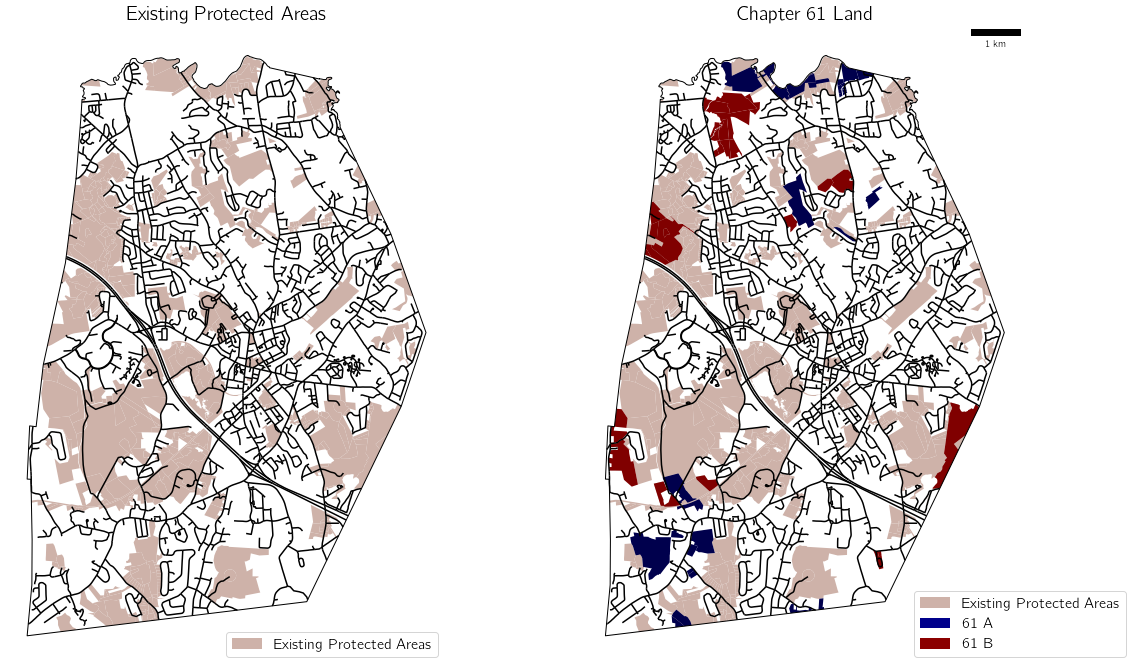

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey="row")

#plot existing protected space
pp.plot(color = "#ceb2a9", ax = ax1)
ax1.set_title("Existing Protected Areas",fontsize=fs)

#plot town outline
f.plot(ax=ax1, color='none', edgecolor='black')
roads.plot(ax = ax1, color = "black")


#create legend
handles = [Patch(facecolor="#ceb2a9", label='Existing Protected Areas') ]
ax1.legend(handles=handles, fontsize=lts, loc='lower right')

ax1.axis('off')


pp.plot(color = "#ceb2a9", ax = ax2)
parcels[~parcels["CH61_TYPE"].isna()].plot("CH61_TYPE",ax = ax2, legend = True, 
                                          cmap = "seismic")

#parcels.plot("mean_dev",cmap = "viridis", ax = ax, legend= True)
roads.plot(ax = ax2, color = "black")

f.plot(ax=ax2, color='none', edgecolor='black')
ax2.add_artist(ScaleBar(1))
#ax.add_artist(ScaleBar(1))
ax2.set_title("Chapter 61 Land",fontsize=fs)

handles = [Patch(facecolor="#ceb2a9", label='Existing Protected Areas'),
           Patch(facecolor = "darkblue", label = "61 A"),
           Patch(facecolor = "darkred", label = "61 B")]
ax2.legend(handles=handles,bbox_to_anchor=(1.25,0), fontsize=lts, loc='lower right')
ax2.axis('off')

fig.set_size_inches(19,19/1.618)

plt.savefig('figures/existing_prot.png', bbox_inches='tight')

## Ch 61 land

In [11]:

fig.set_size_inches(19,19/1.618)


plt.savefig('figures/ch61.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

# Priority Habitat

In [12]:
out = pd.DataFrame()

In [13]:
npp_pr = npp[npp["priha_m2"]>0]

#optimal allocation
npp_pr_op = priority_parcels(npp_pr,"cost_priha")
out = outcomes("Opt. Priority Habitat", npp_pr_op, "priha_m2", out)

#largest parcels
npp_pr_lg = priority_parcels2(npp_pr,"priha_m2")
out = outcomes("Largest Priority Habitat", npp_pr_lg, "priha_m2", out)

#least expensive
npp_pr_le = priority_parcels(npp_pr,"t_as_val_x")
out = outcomes("Least expensive Priority Habitat", npp_pr_le, "priha_m2", out)

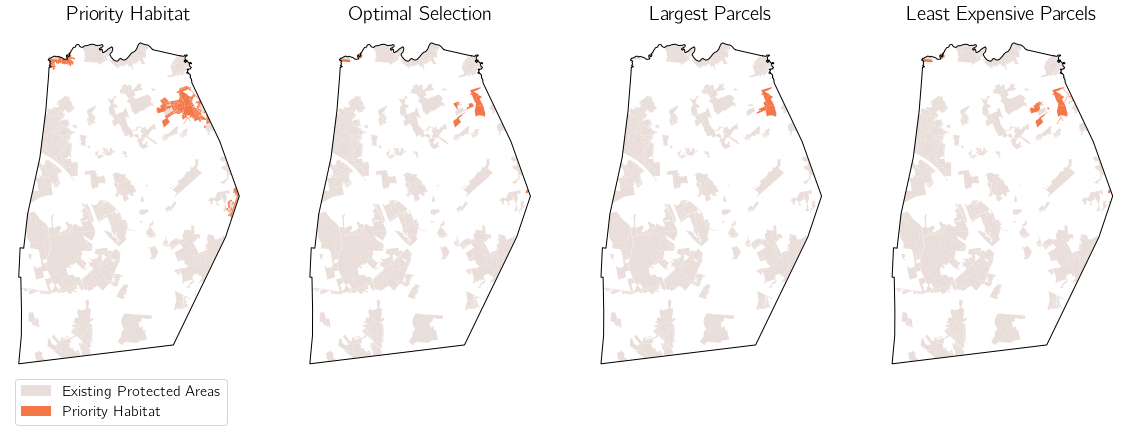

In [14]:
plot_scenarios(npp_pr, npp_pr_op,npp_pr_lg, npp_pr_le, pr, "Priority Habitat", "prihab.png" )

# Forest Cover

In [15]:
npp_forest = npp[npp["for_m2"]>=4046.8564224]

#optimal allocation
npp_fo_op = priority_parcels(npp_forest,"cost_for_m")
out = outcomes("Opt. Forest", npp_fo_op, "for_m2", out)

#largest parcels
npp_fo_lg = priority_parcels2(npp_forest,"for_m2")
out = outcomes("Largest Forest", npp_fo_lg, "for_m2", out)

#least expensive
npp_fo_le = priority_parcels(npp_forest,"t_as_val_x")
out = outcomes("Least expensive Forest", npp_fo_le, "for_m2", out)

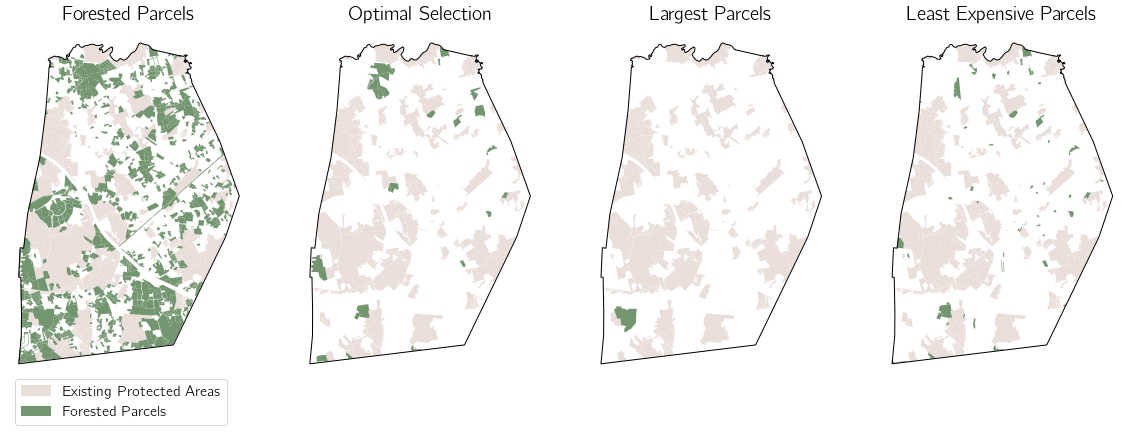

In [16]:
plot_scenarios(npp_forest, npp_fo_op,npp_fo_lg, npp_fo_le, fo, "Forested Parcels", "forest.png" )

# Wetlands

In [17]:
npp_wet = npp[npp["wet_m2"]>=4046.8564224]

#optimal allocation
npp_we_op = priority_parcels(npp_wet,"cost_wet_m")
out = outcomes("Opt. Wetlands", npp_we_op, "wet_m2", out)

#largest parcels
npp_we_lg = priority_parcels2(npp_wet,"wet_m2")
out = outcomes("Largest Wetlands", npp_we_lg, "wet_m2", out)

#least expensive
npp_we_le = priority_parcels(npp_wet,"t_as_val_x")
out = outcomes("Least expensive Wet", npp_we_le, "wet_m2", out)

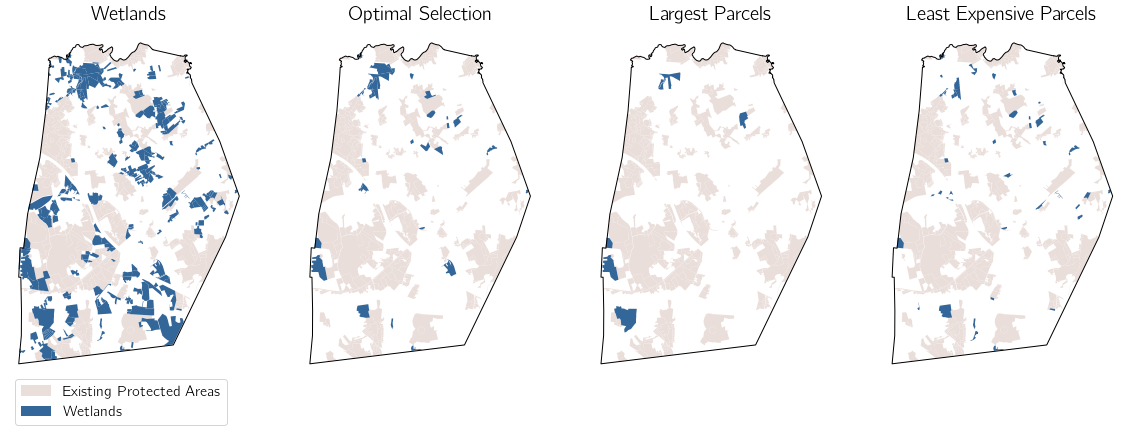

In [18]:
plot_scenarios(npp_wet, npp_we_op,npp_we_lg, npp_we_le, we, "Wetlands", "wetland.png" )

# Undeveloped Land

In [19]:
npp_ndev = npp[((npp["ndev_m2"] > 4046.8564224) & (npp["mean_dev"] <= 0.5))]

#optimal allocation
npp_nd_op = priority_parcels(npp_ndev,"cost_ndev_")
out = outcomes("Opt. Non-Dev", npp_nd_op, "ndev_m2", out)

#largest parcels
npp_nd_lg = priority_parcels2(npp_ndev,"wet_m2")
out = outcomes("Largest Non-Dev", npp_nd_lg, "ndev_m2", out)

#least expensive parcels
#parcels = ascending 
#parcesl2 = descending

npp_nd_le = priority_parcels(npp_ndev,"t_as_val_x")
out = outcomes("Least expensive Non-Dev", npp_nd_le, "ndev_m2", out)

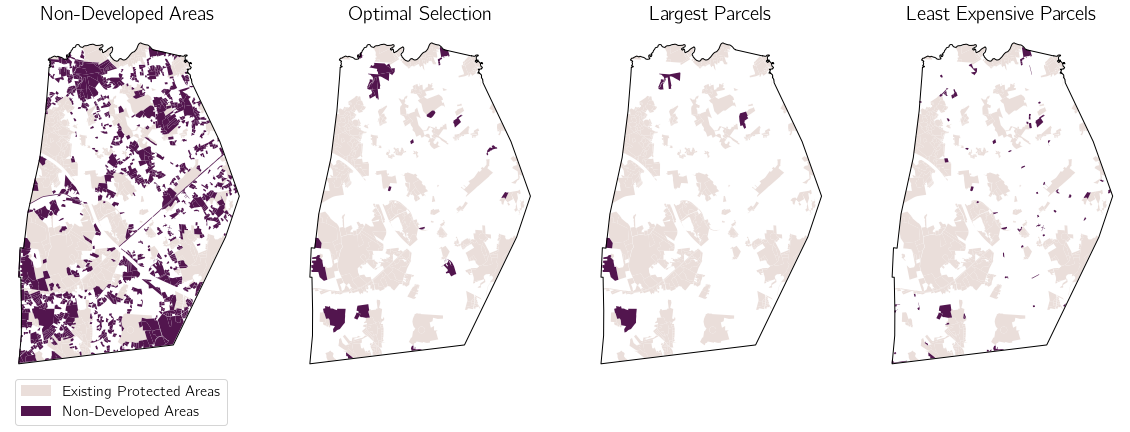

In [20]:
plot_scenarios(npp_ndev, npp_nd_op,npp_nd_lg, npp_nd_le, nd, "Non-Developed Areas", "ndev.png" )

# Results

In [21]:
out

,scenario,n,area_acre,metric_area_acre,budget
0,Opt. Priority Habitat,13,114.022296,85.384839,860596.0
0,Largest Priority Habitat,4,81.562367,71.435858,868600.0
0,Least expensive Priority Habitat,17,130.848500,79.645204,990596.0
0,Opt. Forest,27,474.780610,300.139635,981484.0
0,Largest Forest,1,114.101253,63.197404,431590.0
0,Least expensive Forest,56,277.620677,157.836248,982575.0
0,Opt. Wetlands,31,445.439934,193.296104,897584.0
0,Largest Wetlands,5,282.531762,96.106370,741653.0
0,Least expensive Wet,41,253.058467,121.263947,976577.0
0,Opt. Non-Dev,28,528.050633,511.165694,961247.0


# Exclude CH 61 land

In [22]:
parcels = parcels[parcels["CH61_TYPE"].isna()]
npp = parcels[(parcels["LEV_PROT"] != "P") & (parcels["LEV_PROT"] != "T")& 
              (parcels["LEV_PROT"] != "L") & (parcels["LEV_PROT"] != "N") & (parcels["LEV_PROT"] != "X")]
              #& parcels["CH61_TYPE"].isna()]
npp = npp[npp['t_as_val_x']>0]



pp =parcels[(parcels["LEV_PROT"] == "P") | (parcels["LEV_PROT"] == "T")|
            (parcels["LEV_PROT"] == "L") | (parcels["LEV_PROT"]== "N") | (parcels["LEV_PROT"] == "X")] #| ~(parcels["CH61_TYPE"].isna())]

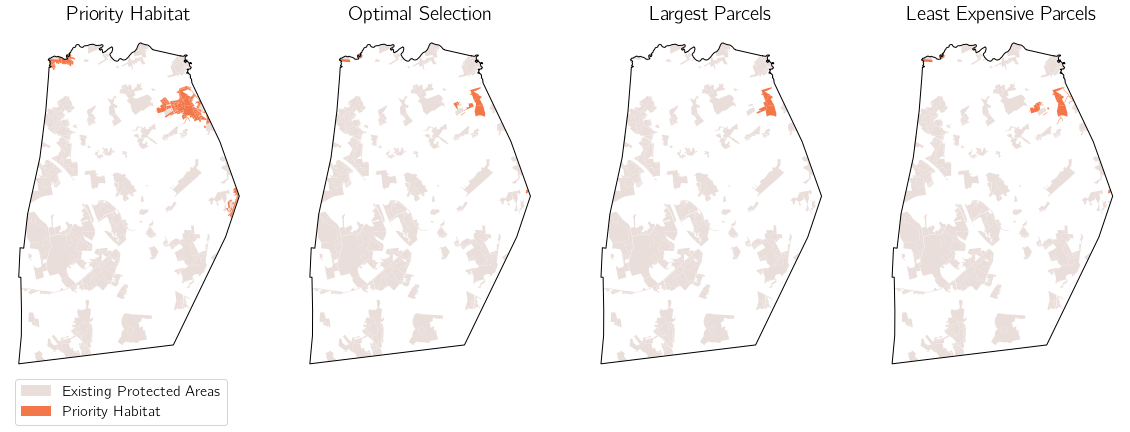

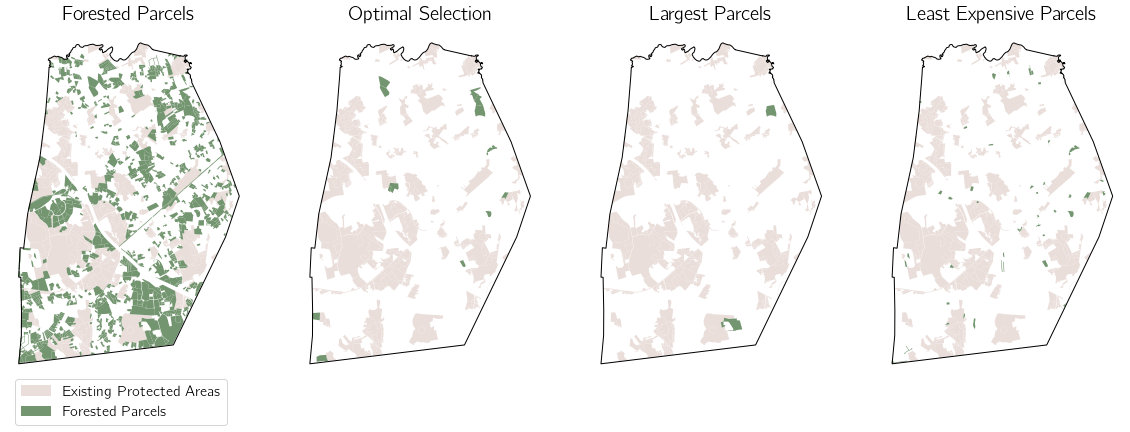

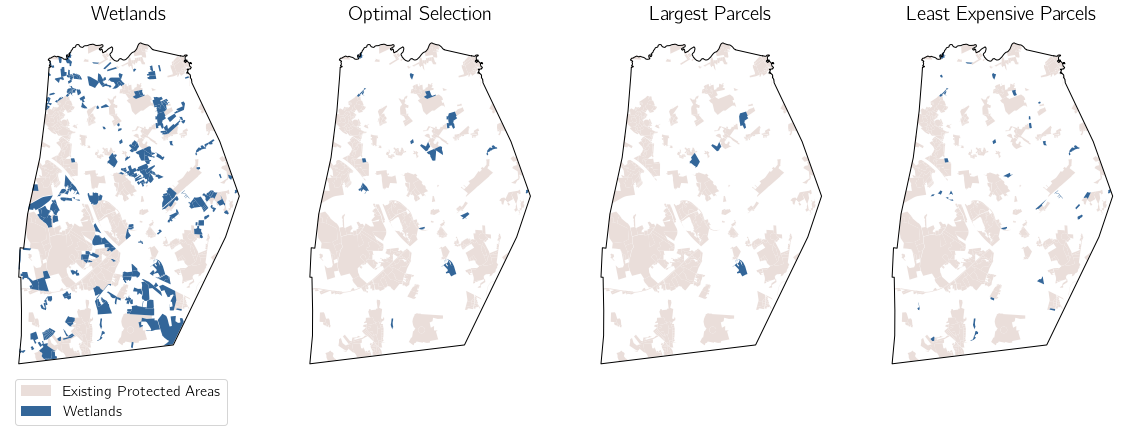

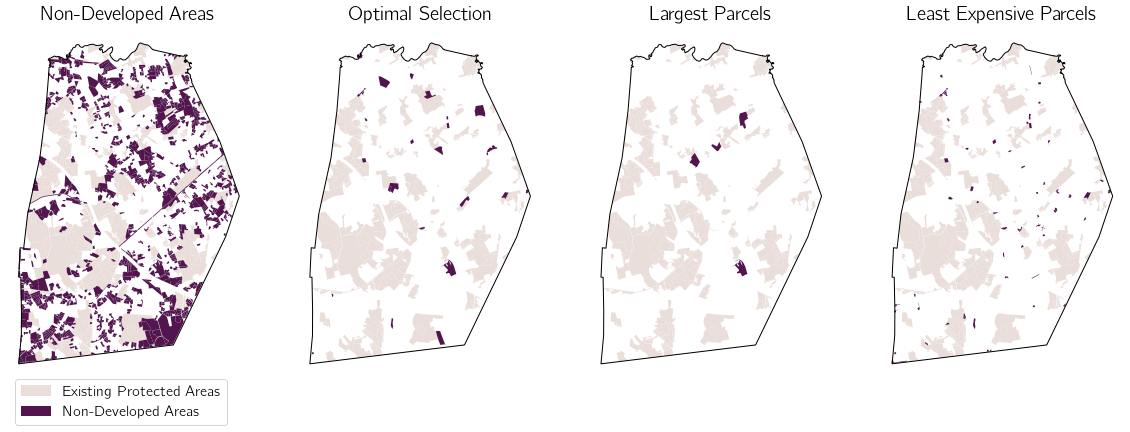

In [23]:
# Priority Habitat
npp_pr = npp[npp["priha_m2"]>0]

#optimal allocation
npp_pr_op = priority_parcels( npp_pr,"cost_priha")
out = outcomes("No Ch.61- Opt. Priority Habitat", npp_pr_op, "priha_m2", out)

#largest parcels
npp_pr_lg = priority_parcels2(npp_pr,"priha_m2")
out = outcomes("No Ch.61-Largest Priority Habitat", npp_pr_lg, "priha_m2", out)

#least expensive
npp_pr_le = priority_parcels(npp_pr,"t_as_val_x")
out = outcomes("No Ch.61-Least expensive Priority Habitat", npp_pr_le, "priha_m2", out)

plot_scenarios(npp_pr, npp_pr_op,npp_pr_lg, npp_pr_le, pr, "Priority Habitat", "n_61prihab.png" )

# Forest Cover

npp_forest = npp[npp["for_m2"]>=4046.8564224]

#optimal allocation
npp_fo_op = priority_parcels(npp_forest,"cost_for_m")
out = outcomes("No Ch.61-Opt. Forest", npp_fo_op, "for_m2", out)

#largest parcels
npp_fo_lg = priority_parcels2(npp_forest,"for_m2")
out = outcomes("No Ch.61-Largest Forest", npp_fo_lg, "for_m2", out)

#least expensive
npp_fo_le = priority_parcels(npp_forest,"t_as_val_x")
out = outcomes("No Ch.61-Least expensive Forest", npp_fo_le, "for_m2", out)

plot_scenarios(npp_forest, npp_fo_op,npp_fo_lg, npp_fo_le, fo, "Forested Parcels", "n_61forest.png" )

# Wetlands

npp_wet = npp[npp["wet_m2"]>=4046.8564224]

#optimal allocation
npp_we_op = priority_parcels(npp_wet,"cost_wet_m")
out = outcomes("No Ch.61-Opt. Wetlands", npp_we_op, "wet_m2", out)

#largest parcels
npp_we_lg = priority_parcels2(npp_wet,"wet_m2")
out = outcomes("No Ch.61-Largest Wetlands", npp_we_lg, "wet_m2", out)

#least expensive
npp_we_le = priority_parcels(npp_wet,"t_as_val_x")
out = outcomes("No Ch.61-Least expensive Wet", npp_we_le, "wet_m2", out)

plot_scenarios(npp_wet, npp_we_op,npp_we_lg, npp_we_le, we, "Wetlands", "n_61wetland.png" )

# Undeveloped Land

npp_ndev = npp[((npp["ndev_m2"] > 4046.8564224) & (npp["mean_dev"] <= 0.5))]

#optimal allocation
npp_nd_op = priority_parcels(npp_ndev,"cost_ndev_")
out = outcomes("No Ch.61-Opt. Non-Dev", npp_nd_op, "ndev_m2", out)

#largest parcels
npp_nd_lg = priority_parcels2(npp_ndev,"wet_m2")
out = outcomes("No Ch.61-Largest Non-Dev", npp_nd_lg, "ndev_m2", out)

#least expensive parcels
#parcels = ascending 
#parcesl2 = descending

npp_nd_le = priority_parcels(npp_ndev,"t_as_val_x")
out = outcomes("No Ch.61-Least expensive Non-Dev", npp_nd_le, "ndev_m2", out)

plot_scenarios(npp_ndev, npp_nd_op,npp_nd_lg, npp_nd_le, nd, "Non-Developed Areas", "n_61ndev.png" )

In [24]:
out.to_csv()
out

,scenario,n,area_acre,metric_area_acre,budget
0,Opt. Priority Habitat,13,114.022296,85.384839,860596.0
0,Largest Priority Habitat,4,81.562367,71.435858,868600.0
0,Least expensive Priority Habitat,17,130.848500,79.645204,990596.0
0,Opt. Forest,27,474.780610,300.139635,981484.0
0,Largest Forest,1,114.101253,63.197404,431590.0
0,Least expensive Forest,56,277.620677,157.836248,982575.0
0,Opt. Wetlands,31,445.439934,193.296104,897584.0
0,Largest Wetlands,5,282.531762,96.106370,741653.0
0,Least expensive Wet,41,253.058467,121.263947,976577.0
0,Opt. Non-Dev,28,528.050633,511.165694,961247.0


# Next Steps

In [25]:
#next steps -- consider existing land connections etc. 